In [2]:
!pip install torch
!pip install matplotlib
!pip install SimpleITK
!pip install pandas

     |████████████████████████████████| 48.4 MB 22 kB/s 


In [ ]:
!pip install tensorboard

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os
from torchvision.io import read_image
from PIL import Image
import pandas as pd
from torch import reshape
import torchvision
from torchvision import transforms

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Conv3d
from torch.optim import Adam, SGD
from torch.utils.tensorboard import SummaryWriter

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/My Drive/Mphys project

/content/gdrive/My Drive/Mphys project


In [ ]:
tb = SummaryWriter()

In [ ]:
!tensorboard --logdir = content/logsdir

usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
   

In [6]:
class segmenter_dataset(data.Dataset):
    def __init__(self, imagedir, maskdir, image_inds, n_classes, shift_augment=True, rotate_augment=True, scale_augment=True, flip_augment=False):
        self.imagedir = imagedir
        self.maskdir = maskdir
        self.availableImages = [sorted(getFiles(imagedir))[ind] for ind in image_inds]
        self.image_inds = image_inds
        self.n_classes = n_classes
        self.shifts = shift_augment
        self.flips = flip_augment
        self.rotations = rotate_augment
        self.scaling = scale_augment
        self.ignore_oars = np.load(os.path.join(source_dir, "labels_present.npy"))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
           idx = idx.tolist()
        imageToUse = self.availableImages[idx]
        spacing = np.load(os.path.join(source_dir, "spacings_scaled.npy"))[idx][[2,0,1]]
        ct_im = np.load(os.path.join(self.imagedir, imageToUse))
        mask = np.load(os.path.join(self.maskdir, imageToUse))
        ignore_index = self.ignore_oars[self.image_inds[idx]]

        # Augmentations
        if self.shifts:
            mx_x, mx_yz = 2, 4
            # find shift values
            cc_shift, ap_shift, lr_shift = random.randint(-mx_x,mx_x), random.randint(-mx_yz,mx_yz), random.randint(-mx_yz,mx_yz)
            # pad for shifting into
            ct_im = np.pad(ct_im, pad_width=((mx_x,mx_x),(mx_yz,mx_yz),(mx_yz,mx_yz)), mode='constant', constant_values=-1024)
            mask = np.pad(mask, pad_width=((mx_x,mx_x),(mx_yz,mx_yz),(mx_yz,mx_yz)), mode='constant', constant_values=0)
            # crop to complete shift
            ct_im = ct_im[mx_x+cc_shift:input_size[0]+mx_x+cc_shift, mx_yz+ap_shift:input_size[1]+mx_yz+ap_shift, mx_yz+lr_shift:input_size[2]+mx_yz+lr_shift]
            mask = mask[mx_x+cc_shift:input_size[0]+mx_x+cc_shift, mx_yz+ap_shift:input_size[1]+mx_yz+ap_shift, mx_yz+lr_shift:input_size[2]+mx_yz+lr_shift]

        if self.rotations and random.random()<0.5:
            # taking implementation from my 3DSegmentationNetwork which can be applied -> rotations in the axial plane only I should think? -10->10 degrees?
            roll_angle = np.clip(np.random.normal(loc=0,scale=3), -10, 10)
            ct_im = self.rotation(ct_im, roll_angle, rotation_plane=(1,2), is_mask=False)
            mask = self.rotation(mask, roll_angle, rotation_plane=(1,2), is_mask=True)

        if self.scaling and random.random()<0.5:
            # same here -> zoom between 80-120%
            scale_factor = np.clip(np.random.normal(loc=1.0,scale=0.05), 0.8, 1.2)
            ct_im = self.scale(ct_im, scale_factor, is_mask=False)
            mask = self.scale(mask, scale_factor, is_mask=True)
            spacing /= scale_factor
        
        if self.flips:
            raise NotImplementedError # LR flips shouldn't be applied I don't think
    
        # perform window-levelling here, create 3 channels
        ct_im3 = np.zeros(shape=(2,) + ct_im.shape)
        ct_im3[0] = windowLevelNormalize(ct_im, level=50, window=400)   # abdomen "soft tissues"
        ct_im3[1] = windowLevelNormalize(ct_im, level=60, window=100)   # pancreas
        
        # use one-hot masks
        mask = (np.arange(self.n_classes) == mask[...,None]).astype(int)
        mask = np.transpose(mask, axes=(3,0,1,2))

        # send it
        return {'ct_im': ct_im3, 'mask': mask, 'ignore_index': ignore_index, 'spacing': spacing}
        
    def __len__(self):
        return len(self.availableImages)

    def scale(self, image, scale_factor, is_mask):
        # scale the image or mask using scipy zoom function
        order, cval = (0, 0) if is_mask else (3, -1024)
        height, width, depth = image.shape
        zheight = int(np.round(scale_factor*height))
        zwidth = int(np.round(scale_factor*width))
        zdepth = int(np.round(scale_factor*depth))
        # zoomed out
        if scale_factor < 1.0:
            new_image = np.full_like(image, cval)
            ud_buffer = (height-zheight) // 2
            ap_buffer = (width-zwidth) // 2
            lr_buffer = (depth-zdepth) // 2
            new_image[ud_buffer:ud_buffer+zheight, ap_buffer:ap_buffer+zwidth, lr_buffer:lr_buffer+zdepth] = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
            return new_image
        elif scale_factor > 1.0:
            new_image = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
            ud_extra = (new_image.shape[0] - height) // 2
            ap_extra = (new_image.shape[1] - width) // 2
            lr_extra = (new_image.shape[2] - depth) // 2
            new_image = new_image[ud_extra:ud_extra+height, ap_extra:ap_extra+width, lr_extra:lr_extra+depth]
            return new_image
        return image
    
    def rotation(self, image, rotation_angle, rotation_plane, is_mask):
        # rotate the image or mask using scipy rotate function
        order, cval = (0, 0) if is_mask else (3, -1024)
        return rotate(input=image, angle=rotation_angle, axes=rotation_plane, reshape=False, order=order, mode='constant', cval=cval)
    

NameError: ignored

In [101]:
idx = 0
transform = ToTensor()
croppath = "cropped niftys short"

class Normalize():
  def __init__(self):
    pass
  
  # def __call__(self, sample):
  #   inputs, targets = sample
  #   inputs = transforms.Normalize(mean = 0.5, std = 0.5)
  #   return inputs, targets
  def __call__(self,vol):
    print("vol")
    vol =(vol-vol.mean())/vol.std()
    return vol

# transform = transforms.Compose(
#     [Normalize() ] #added at 11:00pm 13/12/2021 to normalize the inputs. THIS NORMALIZES to mean = 0 and std = -1(from Rory)
# )

class CustomImageDataset():
    def __init__(self, croppath, transform=transform, target_transfrom=None, shift_augment=False, rotate_augment=False, scale_augment=False, flip_augment=False):
        #self.img_labels = pd.read_csv("/mnt/c/Users/Patrick/Documents/NSCLC Radiomics Lung1.clinical-version3-Oct 2019(1).csv")
        self.img_labels = pd.read_csv("cancerdata.csv")
        self.img_dir = croppath
        self.transform=transform
        self.target_transform=target_transfrom
        self.shifts = shift_augment
        self.flips = flip_augment
        self.rotations = rotate_augment
        self.scaling = scale_augment

    def __len__ (self):
        return len(self.img_labels)

    def __getitem__ (self, idx):
        img_path = os.path.join(self.img_dir, f"{self.img_labels.iloc[idx, 0]}-GTV-1.nii")
        image = sitk.ReadImage(img_path)
        array = sitk.GetArrayFromImage(image)
        tensor = torch.from_numpy(array)
        time_to_death = self.img_labels.iloc[idx,8]
        dead_status = self.img_labels.iloc[idx,9]
        # if self.transform :
        #   image = self.transform(image)
        if time_to_death < 1.5*365 and dead_status == 1:
            label=1
        else:
            label=0
        print(tensor, label)
        return(tensor, label)
        # if self.shifts:
        #     mx_x, mx_yz = 2, 4
        #     # find shift values
        #     cc_shift, ap_shift, lr_shift = np.random.randint(-mx_x,mx_x), np.random.randint(-mx_yz,mx_yz), np.random.randint(-mx_yz,mx_yz)
        #     # pad for shifting into
        #     tensor = np.pad(tensor, pad_width=((mx_x,mx_x),(mx_yz,mx_yz),(mx_yz,mx_yz)), mode='constant', constant_values=-1024)
        #     #mask = np.pad(mask, pad_width=((mx_x,mx_x),(mx_yz,mx_yz),(mx_yz,mx_yz)), mode='constant', constant_values=0)
        #     # crop to complete shift
        #     tensor = tensor[mx_x+cc_shift:input_size[0]+mx_x+cc_shift, mx_yz+ap_shift:input_size[1]+mx_yz+ap_shift, mx_yz+lr_shift:input_size[2]+mx_yz+lr_shift]
        #     #mask = mask[mx_x+cc_shift:input_size[0]+mx_x+cc_shift, mx_yz+ap_shift:input_size[1]+mx_yz+ap_shift, mx_yz+lr_shift:input_size[2]+mx_yz+lr_shift]

        # if self.rotations and np.random.random()<0.5:
        #     # taking implementation from my 3DSegmentationNetwork which can be applied -> rotations in the axial plane only I should think? -10->10 degrees?
        #     roll_angle = np.clip(np.random.normal(loc=0,scale=3), -10, 10)
        #     ct_im = self.rotation(tensor, roll_angle, rotation_plane=(1,2), is_mask=False)
        #     #mask = self.rotation(mask, roll_angle, rotation_plane=(1,2), is_mask=True)

        # if self.scaling and np.random.random()<0.5:
        #     # same here -> zoom between 80-120%
        #     scale_factor = np.clip(np.random.normal(loc=1.0,scale=0.05), 0.8, 1.2)
        #     ct_im = self.scale(ct_im, scale_factor, is_mask=False)
        #     #mask = self.scale(mask, scale_factor, is_mask=True)
        #     #spacing /= scale_factor
        
        # if self.flips:
        #     raise NotImplementedError # LR flips shouldn't be applied I don't think



    # def scale(self, image, scale_factor, is_mask):
    #     # scale the image or mask using scipy zoom function
    #     order, cval = (0, 0) if is_mask else (3, -1024)
    #     height, width, depth = image.shape
    #     zheight = int(np.round(scale_factor*height))
    #     zwidth = int(np.round(scale_factor*width))
    #     zdepth = int(np.round(scale_factor*depth))
    #     # zoomed out
    #     if scale_factor < 1.0:
    #         new_image = np.full_like(image, cval)
    #         ud_buffer = (height-zheight) // 2
    #         ap_buffer = (width-zwidth) // 2
    #         lr_buffer = (depth-zdepth) // 2
    #         new_image[ud_buffer:ud_buffer+zheight, ap_buffer:ap_buffer+zwidth, lr_buffer:lr_buffer+zdepth] = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
    #         return new_image
    #     elif scale_factor > 1.0:
    #         new_image = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
    #         ud_extra = (new_image.shape[0] - height) // 2
    #         ap_extra = (new_image.shape[1] - width) // 2
    #         lr_extra = (new_image.shape[2] - depth) // 2
    #         new_image = new_image[ud_extra:ud_extra+height, ap_extra:ap_extra+width, lr_extra:lr_extra+depth]
    #         return new_image
    #     return image
    
    # def rotation(self, image, rotation_angle, rotation_plane, is_mask):
    #     # rotate the image or mask using scipy rotate function
    #     order, cval = (0, 0) if is_mask else (3, -1024)
    #     return rotate(input=image, angle=rotation_angle, axes=rotation_plane, reshape=False, order=order, mode='constant', cval=cval)

        
        
        
        
        
dataset = CustomImageDataset(croppath, ToTensor(), None)
#print(len(dataset))

trainset, valset, testset = torch.utils.data.random_split(dataset, [1,30,9])

In [102]:
train_dataloader = DataLoader(trainset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=4, shuffle=True)

In [103]:
print(len(train_dataloader))

1


In [117]:
X = np.asarray(train_dataloader)

In [119]:
print(X[1])

IndexError: ignored

NameError: ignored

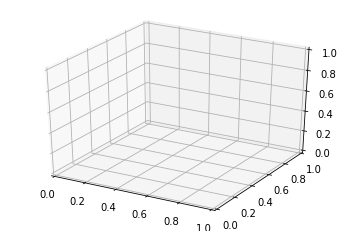

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
print(temp2.shape)
z, y, x = np.where(temp2 > 0)

ax.scatter(x,y,z, c=z, alpha = 1)
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
  
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv3d(1, 4, 3, 1, 1),
            nn.BatchNorm3d(4),#normalises batch
            ReLU(inplace=True),#applies a ReLu to the neurons
            nn.MaxPool3d(kernel_size=2, stride=2),#finds max pool of feature map

            Conv3d(4, 4, 3, 1, 1),#64 neurons per layer
            nn.BatchNorm3d(4),
            ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),

            Conv3d(4, 4, 3, 1, 1),#64 neurons per layer
            nn.BatchNorm3d(4),
            ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),

            Conv3d(4, 4, 3, 1, 1),#64 neurons per layer
            nn.BatchNorm3d(4),
            ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),

            Conv3d(4, 4, 3, 1, 1),#64 neurons per layer
            nn.BatchNorm3d(4),
            ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )
        
        self.linear_layers = Sequential(
            Linear(2048, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)#calls the constructor to execute the convolutions, passes the tensor x and gets the 
        #result of the convolution passed back.
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

model = Net().to(device)
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (13): BatchNorm3d(4, eps=1e-05, 

In [ ]:
from torchsummary import summary
summary(model, (1,264,264,264), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [4, 4, 264, 264, 264]             112
       BatchNorm3d-2      [4, 4, 264, 264, 264]               8
              ReLU-3      [4, 4, 264, 264, 264]               0
         MaxPool3d-4      [4, 4, 132, 132, 132]               0
            Conv3d-5      [4, 4, 132, 132, 132]             436
       BatchNorm3d-6      [4, 4, 132, 132, 132]               8
              ReLU-7      [4, 4, 132, 132, 132]               0
         MaxPool3d-8         [4, 4, 66, 66, 66]               0
            Conv3d-9         [4, 4, 66, 66, 66]             436
      BatchNorm3d-10         [4, 4, 66, 66, 66]               8
             ReLU-11         [4, 4, 66, 66, 66]               0
        MaxPool3d-12         [4, 4, 33, 33, 33]               0
           Conv3d-13         [4, 4, 33, 33, 33]             436
      BatchNorm3d-14         [4, 4, 33,

In [ ]:
import torch.nn.functional as F
class Net2(Module): 
  def __init__(self):
    super(Net2, self).__init__()
    self.conv3d1 = Conv3d(1, 4, 3, 2)
    self.conv3d2 = Conv3d(4, 16, 3, 2)
    self.conv3d3 = Conv3d(16, 64, 2, 2)
    self.conv3d4 = Conv3d(64, 256, 2, 2)
    self.Lin1 = Linear(256, 64)
    self.out = Linear(64,2)
  def forward(self, x):
    x = F.relu(self.conv3d1(x))
    x = F.max_pool3d(x, 2, 2)
    x = F.relu(self.conv3d2(x))
    x = F.max_pool3d(x, 2, 2)
    x = F.relu(self.conv3d3(x))
    x = F.max_pool3d(x, 2, 2)
    x = F.relu(self.conv3d4(x))
    x = F.max_pool3d(x, 2, 2)
    # x = F.relu(self.conv3d5(x))
    # x = F.max_pool3d(x, 2, 2)
    x = x.view(-1, 256)
    x = F.relu(self.Lin1(x))
    #x = torch.flatten(x, start_dim = 1)
    x = self.out(x)
    return(x)
model = Net2().to(device)

In [ ]:
from torchsummary import summary
summary(model, (1,264,264,264), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [4, 4, 131, 131, 131]             112
            Conv3d-2        [4, 16, 32, 32, 32]           1,744
            Conv3d-3           [4, 64, 8, 8, 8]           8,256
            Conv3d-4          [4, 256, 2, 2, 2]         131,328
            Linear-5                    [4, 64]          16,448
            Linear-6                     [4, 2]             130
Total params: 158,018
Trainable params: 158,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 280.76
Forward/backward pass size (MB): 291.49
Params size (MB): 0.60
Estimated Total Size (MB): 572.85
----------------------------------------------------------------


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, total_loss, epoch):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        
             

        # Compute prediction and loss
        X = reshape(X, (X.shape[0],1,264,264,264))
        X = X.float()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        total_loss += loss
    tb.add_scalar("Loss", total_loss, epoch)

def val_loop(dataloader, model, loss_fn, total_correct, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = reshape(X, (X.shape[0],1,264,264,264))
            X = X.float()
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total_correct += correct
    val_loss /= num_batches
  
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    #val_loss.append(test_loss)
    # tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", total_correct/ 28, epoch)#14 is length of trainset
    tb.add_scalar("val loss", val_loss, epoch)

learning_rate = 0.001
# defining the model
model = Net2()
# defining the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# defining the loss function
loss_fn = nn.CrossEntropyLoss()
# checking if GPU is available
model.to(device)
loss_fn.to(device)

CrossEntropyLoss()

In [ ]:
epochs = 1
train_loss = []
val_loss = []


for t in range(epochs):
    loss_temp=[]
    total_loss = 0
    total_correct = 0

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, total_loss, t)
    val_loop(val_dataloader, model, loss_fn, total_correct, t)
    #train_loss.append(loss_temp.pop())
    #print(train_loss, val_loss)
    # plotting the training and validation loss
    # plt.plot(train_loss, label='Training loss')
    # plt.plot(val_loss, label='Validation loss')
    # plt.legend()
    # plt.show()
    tb.add_histogram("conv3d1.bias", model.conv3d1.bias, t)
    tb.add_histogram("conv3d1.weight", model.conv3d1.weight, t)
    tb.add_histogram("conv3d2.bias", model.conv3d2.bias, t)
    tb.add_histogram("conv3d2.weight", model.conv3d2.weight, t)
    tb.add_histogram("conv3d3.bias", model.conv3d3.bias, t)
    tb.add_histogram("conv3d3.weight", model.conv3d3.weight, t)
    tb.add_histogram("conv3d4.bias", model.conv3d4.bias, t)
    tb.add_histogram("conv3d4.weight", model.conv3d4.weight, t)
    tb.add_histogram("Lin1.bias", model.Lin1.bias, t)
    tb.add_histogram("Lin1.weight", model.Lin1.weight, t)
    tb.add_histogram("out.bias", model.out.bias, t)
    tb.add_histogram("out.weight", model.out.weight, t)
    #tb.add_scalar("Accuracy", total_correct/ len(train_set), epoch)


tb.close()
print("Done!")

Epoch 1
-------------------------------
loss: 0.797655  [    0/   24]


KeyboardInterrupt: ignored

In [ ]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = reshape(X, (X.shape[0],1,264,264,264))
            X = X.float()
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
  
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    val_loss.append(test_loss)

In [ ]:
test_loop(test_dataloader, model, loss_fn)

In [ ]:
tb = SummaryWriter()
model = Net()
images, labels = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(images)
tb.add_image("images", grid)
tb.add_graph(model, images)
tb.close()

In [ ]:
network = Net2()
images, labels = next(iter(train_dataloader))
images = reshape(images, (images.shape[0],1,264,264,264))
images = images.float()

tb.add_graph(network, images)
tb.close()

KeyboardInterrupt: ignored